<a href="https://colab.research.google.com/github/vikasjaat47/Chest-X-Ray-Covid-19-Detection/blob/main/Covid_detection_chest_X_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [13]:
from google.colab import files
import os
import pandas as pd
import pathlib 
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix

## Setting Enviorment for Kaggle

In [2]:
# Installing Kaggle
!pip install -q kaggle

In [3]:
# Uploading our kaggle kpi
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vikasjaat47","key":"23797a7b141909b48cafe7ac600ab074"}'}

In [4]:
# creating a kaggle directory
! mkdir ~/.kaggle

In [ ]:
# copy the kaggle.json file into the directory
! cp kaggle.json ~/.kaggle/

In [5]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

# API command of dataset 
!kaggle datasets download -d sid321axn/covid-cxr-image-dataset-research


 99% 566M/572M [00:07<00:00, 82.6MB/s]
100% 572M/572M [00:07<00:00, 75.6MB/s]


In [6]:
# unzip the dataset
!unzip \*.zip

Archive:  covid-cxr-image-dataset-research.zip
  inflating: COVID_IEEE/covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg  
  inflating: COVID_IEEE/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg  
  inflating: COVID_IEEE/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-001.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-002.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b2.pn

In [7]:
# Getting Information of data (Data Structure)
# using os to check name of directory and checking the image in each directory or 
# accesssing image from any directory
for dirpath, dirname,filename in os.walk("/content/COVID_IEEE"):
  print(f"there are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

there are 3 directories and 0 images in '/content/COVID_IEEE'.
there are 0 directories and 668 images in '/content/COVID_IEEE/normal'.
there are 0 directories and 619 images in '/content/COVID_IEEE/virus'.
there are 0 directories and 536 images in '/content/COVID_IEEE/covid'.


# Creating Class labels

In [12]:
# Storing name of these folder beacuse these become our target variable 
data_dir = pathlib.Path("/content/COVID_IEEE")
class_label = np.array([sorted([item.name for item in data_dir.glob("*")])])
class_label

array([['covid', 'normal', 'virus']], dtype='<U6')

# Visualization of Data

In [14]:
# Randomly pick an image fom specified directory and folder 
def Show_Image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder),1) # (target folder address , no of image we want to pick)
  print(f"Random Image path address '{random_image}'")
  print(f"Chest Image of '{target_class}'class ")
  # Using matplotlib image to read input image 
  img = mpimg.imread(target_folder + "/" + random_image[0]) # define path for that random image
  plt.imshow(img, cmap ="gray")
  plt.title(target_class)
  plt.axis("off")
  return img 

Random Image path address '['NORMAL2-IM-0723-0001.jpeg']'
Chest Image of 'normal'class 


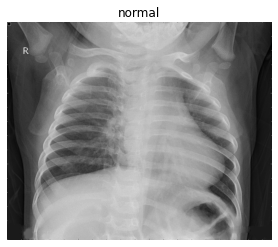

In [15]:
# target dir with / at the end to create a path 
# target class write class we want in string 
img1 = Show_Image("/content/COVID_IEEE/","normal")

Random Image path address '['person29_virus_64.jpeg']'
Chest Image of 'virus'class 


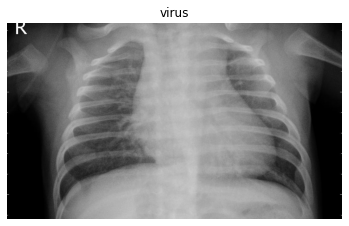

In [16]:
# for virus class
img1 = Show_Image("/content/COVID_IEEE/","virus")

Random Image path address '['EURzhIvXsAY5tyz.jfif']'
Chest Image of 'covid'class 


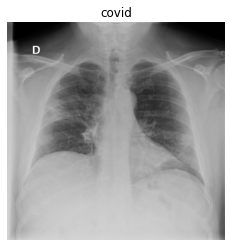

In [17]:
# covid
img1 = Show_Image("/content/COVID_IEEE/","covid")

# Creating dataset for the problem

In [18]:
# Create array of data and label to store all image in one array and labels
data = []
labels = []
img_size = 224


# First for covid class
covid = os.listdir("/content/COVID_IEEE/covid/") # after copy path use "/" at the end to easily join name and path of file 
for image_name_cov in covid:
  img_cov = cv2.imread("/content/COVID_IEEE/covid/"+image_name_cov,) # reading image one by one from covid class
  img_cov = cv2.resize(img_cov, (img_size,img_size)) # for applying cnn all image should be of same size so resize this acc to our choise
  data.append(img_cov)
  labels.append(0) # giving covid class label as 0 


# second for normal class
normal = os.listdir("/content/COVID_IEEE/normal/")
for image_name_nor in normal:
  img_nor = cv2.imread("/content/COVID_IEEE/normal/"+image_name_nor,)
  img_nor = cv2.resize(img_nor, (img_size,img_size))
  data.append(img_nor)
  labels.append(1) # giving normal class label as 1


# thrirdly for virus class
virus = os.listdir("/content/COVID_IEEE/virus/")
for image_name_vir in virus:
  img_vir = cv2.imread("/content/COVID_IEEE/virus/"+image_name_vir,)
  img_vir = cv2.resize(img_vir, (img_size,img_size))
  data.append(img_vir)
  labels.append(2) # giving virus class label as 2 

In [19]:
# creating data list to array and normalizing data for cnn between 0 and 1
img_data = np.array(data)/255.0
img_labels = np.array(labels)

# printing img data
print("img data : \n")
print(img_data)

# printing img label
print("img label : \n")
print(img_labels)

img data : 

[[[[0.0745098  0.0745098  0.0745098 ]
   [0.08235294 0.08235294 0.08235294]
   [0.09019608 0.09019608 0.09019608]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.08235294 0.08235294 0.08235294]
   [0.08235294 0.08235294 0.08235294]
   [0.08627451 0.08627451 0.08627451]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.09019608 0.09019608 0.09019608]
   [0.08627451 0.08627451 0.08627451]
   [0.07843137 0.07843137 0.07843137]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.72156863 0.72156863 0.72156863]
   [0.74117647 0.74117647 0.74117647]
   [0.73333333 0.73333333 0.73333333]
   ...
   [0.58823529 0.58823529 0.58823529]
   [0.58823529 0.58823529 0.58823529]
   [0.58039216 0.58039216 0.58039216]]

  [[0.71372549 0.71372549 0.7137

In [20]:
# Spliting data into train and test set
X_train, X_test, y_train, y_test = train_test_split(img_data, img_labels, test_size=0.20, random_state=0)

# we have multi-class-classification problem 
# change each label into vector form or in One-Hot Encoded label 
y_train = tf.keras.utils.to_categorical(y_train, num_classes= 3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes= 3)

# Building CNN Model

In [21]:
model = Sequential()
model.add(Conv2D(input_shape = (img_size,img_size, 3), filters = 32, padding="same", kernel_size= (3,3)))
model.add(Activation("relu")) 
model.add(Conv2D(filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(filters=64, padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))
model.add(Conv2D(filters=64, padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(filters=64, padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=128, padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))
model.add(Conv2D(filters=128, padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))
model.add(MaxPool2D((2,2)))
model.add(MaxPool2D((2,2))) 

model.add(Flatten()) 
model.add(Dense(units=1024, activation="relu"))
model.add(Dense(units=256, activation="relu"))
model.add(Dense(units=3, activation="softmax"))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [22]:
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                        

In [24]:
# ************************** Train the Model ************************#
model.fit(X_train, y_train , validation_split= 0.3, epochs= 15, batch_size= 32)

Epoch 1/15
32/32 [==============================] - 375s 12s/step - loss: 0.7273 - accuracy: 0.7020 - val_loss: 0.6333 - val_accuracy: 0.8128
Epoch 2/15
32/32 [==============================] - 410s 13s/step - loss: 0.4656 - accuracy: 0.8529 - val_loss: 0.3738 - val_accuracy: 0.8699
Epoch 3/15
32/32 [==============================] - 336s 11s/step - loss: 0.3274 - accuracy: 0.8892 - val_loss: 0.4520 - val_accuracy: 0.8333
Epoch 4/15
32/32 [==============================] - 334s 10s/step - loss: 0.2576 - accuracy: 0.9108 - val_loss: 0.2321 - val_accuracy: 0.9041
Epoch 5/15
32/32 [==============================] - 333s 10s/step - loss: 0.1419 - accuracy: 0.9529 - val_loss: 0.2294 - val_accuracy: 0.9247
Epoch 6/15
32/32 [==============================] - 334s 10s/step - loss: 0.0904 - accuracy: 0.9676 - val_loss: 0.1723 - val_accuracy: 0.9475
Epoch 7/15
32/32 [==============================] - 333s 10s/step - loss: 0.0590 - accuracy: 0.9784 - val_loss: 0.2114 - val_accuracy: 0.9429
Epoch 

## Plotting the results of the model

Text(0.5, 1.0, 'Training-Validation Accuracy')

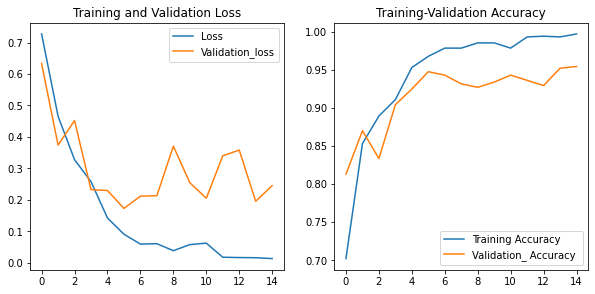

In [25]:
#saving the model history
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy 
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label = "Training Accuracy")
plt.plot(loss['val_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

In [26]:
# Predictions
prediction = model.predict(X_test)

# finding class with larget predicted probability using argmax of numpy 
y_pred = np.argmax(prediction, axis = 1)  # prediction using model 
y_test_orig = np.argmax(y_test, axis = 1) # original y_test

print(classification_report(y_test_orig, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       114
           1       0.94      0.98      0.96       131
           2       0.97      0.89      0.93       120

    accuracy                           0.95       365
   macro avg       0.95      0.95      0.95       365
weighted avg       0.95      0.95      0.95       365



In [27]:
# visualize confusion_metric
label = ['covid', 'normal', 'virus']
pd.DataFrame(confusion_matrix(y_test_orig, y_pred), columns= label, index = label)


,covid,normal,virus
covid,113,0,1
normal,1,128,2
virus,5,8,107


## Transfer Learning

use MobileNet model's weights which is train on imagenet data and make our base model

In [28]:
# MobilNet as Base Model 

# include_top = False
# ------ beacuse we don't want last layer which is prediction layer
base_model = tf.keras.applications.MobileNet(input_shape=[img_size,img_size,3],
                                             weights = 'imagenet',
                                             include_top=False)
# layer.trainable = Flase 
# ------ becuase we want the pre-trained weights and don't want to train them on our data.
for layer in base_model.layers:
  layer.trainable = False

17235968/17225924 [==============================] - 0s 0us/step


In [29]:
# *********************************ADD OUR OWN LAYER ***********************************#

# first flatten the output coming from MobileNet architecture
model = Flatten()(base_model.output) 

# adding dense layer to the network
model = Dense(units=1024, activation='relu')(model)
model = Dense(units=512, activation='relu')(model)
model = Dense(units=256, activation='relu')(model)

# Create Prediction Layer
prediction_layer = Dense(units=3, activation='softmax')(model)

In [30]:
# *********************** MERGING OUR MODEL AND MobileNet MODEL ***********************#

# model will have MobilNet as input layer and our model as output layer
model = Model(inputs = base_model.input, outputs = prediction_layer)

# compile model 
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [32]:
# ************************** Train the New Model ************************#
model.fit(X_train, y_train , validation_split= 0.3, epochs= 15, batch_size= 32)

Epoch 1/15
32/32 [==============================] - 55s 2s/step - loss: 6.2126 - accuracy: 0.7892 - val_loss: 0.9496 - val_accuracy: 0.9292
Epoch 2/15
32/32 [==============================] - 53s 2s/step - loss: 0.5102 - accuracy: 0.9510 - val_loss: 1.0694 - val_accuracy: 0.9224
Epoch 3/15
32/32 [==============================] - 52s 2s/step - loss: 0.1481 - accuracy: 0.9863 - val_loss: 0.5559 - val_accuracy: 0.9452
Epoch 4/15
32/32 [==============================] - 53s 2s/step - loss: 0.1840 - accuracy: 0.9784 - val_loss: 1.5063 - val_accuracy: 0.9041
Epoch 5/15
32/32 [==============================] - 53s 2s/step - loss: 0.5449 - accuracy: 0.9569 - val_loss: 0.6544 - val_accuracy: 0.9566
Epoch 6/15
32/32 [==============================] - 53s 2s/step - loss: 0.1491 - accuracy: 0.9863 - val_loss: 0.7616 - val_accuracy: 0.9612
Epoch 7/15
32/32 [==============================] - 53s 2s/step - loss: 0.0268 - accuracy: 0.9971 - val_loss: 0.5814 - val_accuracy: 0.9658
Epoch 8/15
32/32 [==

Text(0.5, 1.0, 'Training-Validation Accuracy')

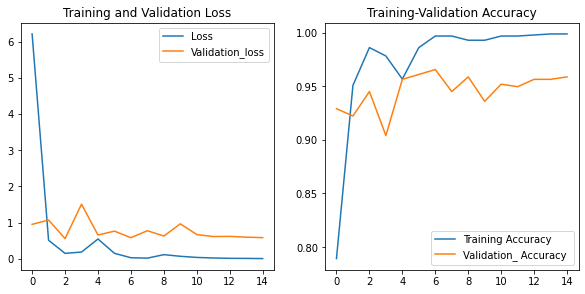

In [33]:
#saving the model history
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy 
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label = "Training Accuracy")
plt.plot(loss['val_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

In [34]:
prediction = model.predict(X_test)

# finding class with larget predicted probability using argmax of numpy 
y_pred = np.argmax(prediction, axis = 1)  # prediction using model 
y_test_orig = np.argmax(y_test, axis = 1) # original y_test

print(classification_report(y_test_orig, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       114
           1       0.96      1.00      0.98       131
           2       1.00      0.94      0.97       120

    accuracy                           0.98       365
   macro avg       0.98      0.98      0.98       365
weighted avg       0.98      0.98      0.98       365



In [35]:
# visualize confusion_metric
label = ['covid', 'normal', 'virus']
pd.DataFrame(confusion_matrix(y_test_orig, y_pred), columns= label, index = label)

,covid,normal,virus
covid,114,0,0
normal,0,131,0
virus,1,6,113
